In [1]:
import tensorflow as tf

In [2]:
print(tf.test.is_gpu_available())#未來將棄用

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [3]:
print(tf.config.list_physical_devices('GPU')) #更改後
device_name=tf.config.list_physical_devices('GPU')
print(device_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow_datasets as tfds

C:\Users\MSI\anaconda3\envs\mypython\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#生成器
def generator_network(num_hidden_layers = 1,num_hidden_units = 100,num_output_units = 784):   #28*28 
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                units = num_hidden_units,use_bias=False))
        model.add(tf.keras.layers.LeakyReLU())
    
    model.add(
        tf.keras.layers.Dense(
            units = num_output_units,activation = 'tanh'))            
    return model

#鑑別器
def discriminator_network(num_hidden_layers = 1,num_hidden_units = 100,num_output_nunits = 1):  #輸出
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.5))
        
    model.add(tf.keras.layers.Dense(num_output_nunits,activation=None))
    
    return model
    
    

# 資料建立、訓練

In [7]:
mnist_bldr = tfds.builder('mnist')
#mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files = False)

In [8]:
def preprocess(ex, mode='uniform'):                         #資料預處理
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])                        #shape=(784,),dtype=float32
    image = image*2 - 1.0
    input_z = tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
    return input_z, image


In [9]:
import time

epochs = 50
batch_size = 64
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

fixed_z = tf.random.uniform(shape = (batch_size, z_size),minval = -1, maxval = 1)

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training = False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

#資料預處理
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(lambda ex: preprocess(ex))            
mnist_trainset = mnist_trainset.shuffle(10000)                            #攪亂
mnist_trainset = mnist_trainset.batch(batch_size, drop_remainder=True)    #每批大小64 小於64刪除

#模組參數設定
with tf.device(device_name = 'GPU'):
    #生成器
    gen_model = generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))
    #鑑別器
    disc_model = discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

#設定損失率及化器
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        #計算生成器的損失
        with tf.GradientTape() as g_tape:                #GradientTape利用計算模型加權的損失梯度
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(grads_and_vars=zip(
                                    g_grads, gen_model.trainable_variables))  
        
        #計算鑑別器損失
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake
            
        #計算 d_loss 的梯度
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Loss'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.42 min | Avg Loss G/D 3.0089/0.3006 [D-Real: 0.0363 D-Fake: 0.2643]
Epoch 002 | ET 0.83 min | Avg Loss G/D 5.3361/0.3106 [D-Real: 0.0934 D-Fake: 0.2172]
Epoch 003 | ET 1.23 min | Avg Loss G/D 3.2358/0.6585 [D-Real: 0.2843 D-Fake: 0.3742]
Epoch 004 | ET 1.65 min | Avg Loss G/D 2.4154/0.8040 [D-Real: 0.4072 D-Fake: 0.3968]
Epoch 005 | ET 2.05 min | Avg Loss G/D 2.0721/0.8331 [D-Real: 0.4526 D-Fake: 0.3805]
Epoch 006 | ET 2.46 min | Avg Loss G/D 1.9393/0.8440 [D-Real: 0.4650 D-Fake: 0.3790]
Epoch 007 | ET 2.86 min | Avg Loss G/D 1.6775/0.9561 [D-Real: 0.5170 D-Fake: 0.4390]
Epoch 008 | ET 3.27 min | Avg Loss G/D 1.4974/0.9785 [D-Real: 0.5395 D-Fake: 0.4389]
Epoch 009 | ET 3.67 min | Avg Loss G/D 1.4082/1.0606 [D-Real: 0.5657 D-Fake: 0.4949]
Epoch 010 | ET 4.08 min | Avg Loss G/D 1.5158/0.9923 [D-Real: 0.5380 D-Fake: 0.4543]
Epoch 011 | ET 4.48 min | Avg Loss G/D 1.3362/1.0743 [D-Real: 0.5740 D-Fake: 0.5002]
Epoch 012 | ET 4.89 min | Avg Loss G/D 1.3089/1.0593 [D-Real: 0.5

In [10]:
#gen_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                 loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])
#
#disc_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                 loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

In [11]:
#gen_model.save('gen.h5')
#disc_model.save('disc.h5')

In [12]:
#from tensorflow.keras.models import load_model
#gen_model = load_model('gen.h5')
#disc_model = load_model('disc.h5')

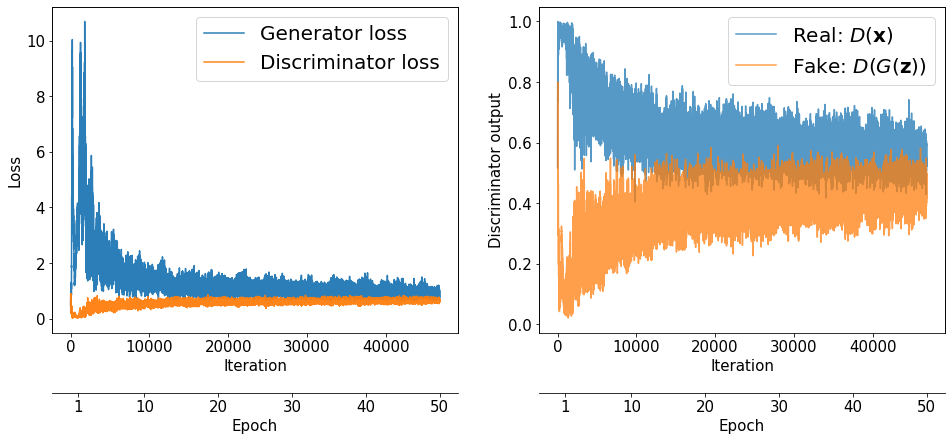

In [13]:
import itertools


fig = plt.figure(figsize=(16, 6))

# 繪製損失率
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 51)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 10, 20, 30, 40, 50]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## 鑑別器輸出
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


plt.savefig('curve.pdf')
plt.show()

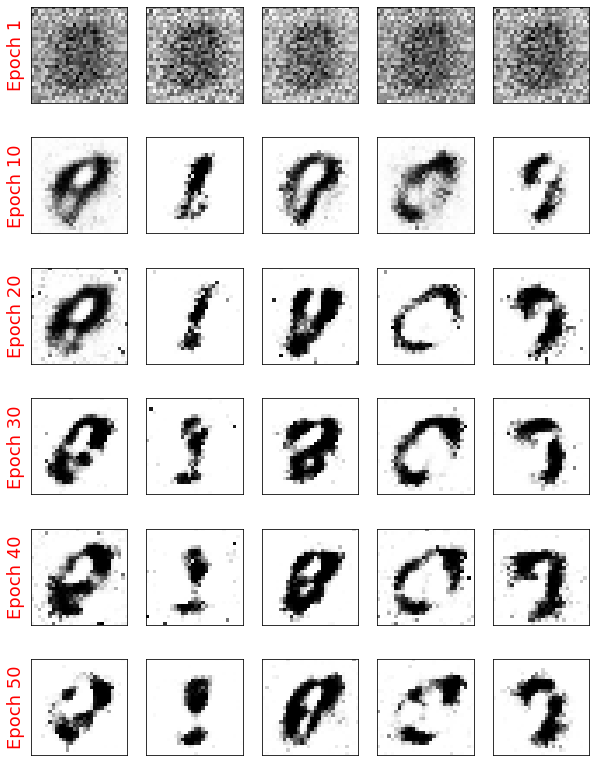

In [16]:
selected_epochs = [1, 10, 20, 30, 40, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.savefig('gan-samples.pdf')
plt.show()